# Data Pre-Processing at SA Level

In [9]:
# Enable Intellisense
%config IPCompleter.greedy=True

import pandas as pd
import numpy as np
import io
import requests
from datetime import timedelta, datetime
import os
import shutil

# Annoying warning
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# get dataframe from specified url using kwargs specified for read_csv
def df_from_url(df_url, pd_kwargs={}, use_base_url=True):
    base_url = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/"
    if use_base_url:
        df_url = base_url + df_url
    df_req = requests.get(df_url).content
    df = pd.read_csv(io.StringIO(df_req.decode('utf-8')), **pd_kwargs)
    return df

# Generator method to get all dates in specified interval
def datetime_range(start_datetime, end_datetime):
    curr_date = start_datetime
    yield curr_date
    while curr_date < end_datetime:
        curr_date += timedelta(days=1)
        yield curr_date

In [3]:
    def get_cum_daily(data_url, cum_col='total', index_col='date'):  # kwargs={}):
        cols = ['date', 'total']
        pd_kwargs = {"usecols": [cum_col, index_col], "index_col": [index_col]}

        data = df_from_url(data_url, pd_kwargs)
        data.reset_index(inplace=True)
        data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y')
        data.set_index('date', inplace=True)
        data.rename({cum_col: "cum_no"}, axis=1, inplace=True)
        data.ffill(inplace=True)

        data['daily_no'] = data['cum_no']
        data['daily_no'][1:] = data['cum_no'].diff()[1:]
        # Cast columns to integer
        data = data.astype('int32')
        return data

In [4]:
confirmed_cases_url = "covid19za_provincial_cumulative_timeline_confirmed.csv"
confirmed_data = get_cum_daily(confirmed_cases_url)
confirmed_data

,cum_no,daily_no
date,,
2020-03-05,1,1
2020-03-07,2,1
2020-03-08,3,1
2020-03-09,7,4
2020-03-11,13,6
...,...,...
2020-12-28,1011871,7458
2020-12-29,1021451,9580
2020-12-30,1039161,17710


In [7]:
confirmed_data.iloc[-1]['cum_no'].astype(int)

883687

In [5]:
confirmed_data.index[-1]

Timestamp('2020-12-16 00:00:00')

## SA Data

In [7]:
# def preprocess_sa_data():
#     def get_cum_daily(data_url, cum_col='total', index_col='date'):  # kwargs={}):
#         cols = ['date', 'total']
#         pd_kwargs = {"usecols": [cum_col, index_col, 'source'], "index_col": [index_col]}

#         data = df_from_url(data_url, pd_kwargs)
#         data.reset_index(inplace=True)
#         data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y')
#         data.set_index('date', inplace=True)
#         data.rename({cum_col: "cum_no"}, axis=1, inplace=True)
#         data.ffill(inplace=True)

#         data['daily_no'] = data['cum_no']
#         data['daily_no'][1:] = data['cum_no'].diff()[1:]
#         # Cast columns to integer
#         data[['cum_no']] = data[['cum_no']].astype('int32')
#         return data

#     confirmed_cases_url = "covid19za_provincial_cumulative_timeline_confirmed.csv"
#     confirmed_data = get_cum_daily(confirmed_cases_url)

#     deaths_url = "covid19za_provincial_cumulative_timeline_deaths.csv"
#     deaths_data = get_cum_daily(deaths_url)

#     tests_url = "covid19za_timeline_testing.csv"
#     tests_data = get_cum_daily(tests_url, 'cumulative_tests', 'date')

#     recovered_data = get_cum_daily(tests_url, 'recovered', 'date')

#     def get_active_cases():
#         _active_data = confirmed_data[['cum_no']].copy().rename({"cum_no": "confirmed"}, axis=1)
#         _active_data = pd.concat([_active_data,
#                                  recovered_data[['cum_no']].copy().rename({"cum_no": "recovered"}, axis=1),
#                                  deaths_data[['cum_no']].copy().rename({"cum_no": "deaths"}, axis=1)
#                                  ], axis=1)
#         _active_data = _active_data.iloc[9:]
#         _active_data = _active_data.ffill().fillna(0)

#         _active_data['cum_no'] = _active_data['confirmed'] - _active_data['recovered'] - _active_data['deaths']
#         _active_data.drop(['confirmed', 'recovered', 'deaths'], axis=1, inplace=True)
#         _active_data['daily_no'] = _active_data['cum_no'].copy()
#         _active_data['daily_no'].iloc[1:] = _active_data['cum_no'].diff().iloc[1:]
#         _active_data = _active_data.astype('int32')

#         return _active_data

#     active_data = get_active_cases()

#     def get_all_cum_data():
#         _all_cum_data = confirmed_data[['cum_no']].rename({"cum_no": "confirmed"}, axis=1)
#         _all_cum_data = pd.concat([
#             _all_cum_data,
#             tests_data[['cum_no']].rename({"cum_no": "tests"}, axis=1),
#             deaths_data[['cum_no']].rename({"cum_no": "deaths"}, axis=1),
#             recovered_data[['cum_no']].rename({"cum_no": "recovered"}, axis=1),
#             active_data[['cum_no']].rename({"cum_no": "active"}, axis=1),

#         ], axis=1)
#         # _all_cum_data['recovered'] = recovered_data['cum_no']
#         # _all_cum_data['active'] = active_data['cum_no']
#         _all_cum_data.ffill(inplace=True)
#         _all_cum_data.fillna(0, inplace=True)
#         _all_cum_data = _all_cum_data.astype('int32')

#         # DERIVED STATS

#         # confirmed_div_by_tests
#         _all_cum_data['confirmed_div_by_tests'] = _all_cum_data['confirmed'] / _all_cum_data['tests']
#         _all_cum_data['confirmed_div_by_tests'] = _all_cum_data['confirmed_div_by_tests'].round(3)

#         # deaths_div_by_confirmed
#         _all_cum_data['deaths_div_by_confirmed'] = _all_cum_data['deaths'] / _all_cum_data['confirmed']
#         _all_cum_data['deaths_div_by_confirmed'] = _all_cum_data['deaths_div_by_confirmed'].round(3)
#         _all_cum_data.fillna(0.000, inplace=True)

#         # recovered_div_by_confirmed
#         _all_cum_data['recovered_div_by_confirmed'] = _all_cum_data['recovered'] / _all_cum_data['confirmed']
#         _all_cum_data['recovered_div_by_confirmed'] = _all_cum_data['recovered_div_by_confirmed'].round(3)
#         _all_cum_data.fillna(0.000, inplace=True)

#         # STATS PER MILLION POP

#         sa_tot_population = 59195720
#         # total population rounded in millions
#         sa_tot_pop_mil = sa_tot_population / 1000000

#         _all_cum_data['confirmed_per_mil'] = _all_cum_data['confirmed'] / sa_tot_pop_mil
#         _all_cum_data['tests_per_mil'] = _all_cum_data['tests'] / sa_tot_pop_mil
#         _all_cum_data['deaths_per_mil'] = _all_cum_data['deaths'] / sa_tot_pop_mil
#         _all_cum_data['recovered_per_mil'] = _all_cum_data['recovered'] / sa_tot_pop_mil
#         _all_cum_data['active_per_mil'] = _all_cum_data['active'] / sa_tot_pop_mil
#         tmp_cols = ['confirmed_per_mil', 'tests_per_mil', 'deaths_per_mil', 'recovered_per_mil', 'active_per_mil']
#         _all_cum_data[tmp_cols] = _all_cum_data[tmp_cols].round(2)
#         _all_cum_data.fillna(0.00, inplace=True)

#         return _all_cum_data

#     # All cumulative data
#     all_cum_data = get_all_cum_data()
# #     all_cum_data.to_csv('data/sa/all_cum_data.csv')

#     def get_all_daily_data():
#         _all_daily_data = confirmed_data[['daily_no']].rename({"daily_no": "confirmed"}, axis=1)
#         cols_to_use = ['daily_no'] 
#         _all_daily_data = pd.concat([
#             _all_daily_data,
#             tests_data[cols_to_use].rename({"daily_no": "tests"}, axis=1),
#             deaths_data[cols_to_use].rename({"daily_no": "deaths"}, axis=1),
#             recovered_data[cols_to_use].rename({"daily_no": "recovered"}, axis=1),
#             active_data[cols_to_use].rename({"daily_no": "active"}, axis=1),

#         ], axis=1)
#         _all_daily_data.ffill(inplace=True)
#         _all_daily_data.fillna(0, inplace=True)
#         _all_daily_data = _all_daily_data.astype('int32')
#         return _all_daily_data

#     # All daily data
#     all_daily_data = get_all_daily_data()
# #     all_daily_data.to_csv("data/sa/all_daily_data.csv")

#     def get_index_page_data():
#         def zero_space_format(num):
#             is_pos = True if num >= 0 else False
#             num = zero_space(num)
#             if is_pos:
#                 num = "+" + num
#             else:
#                 num = "-" + num

#             return num

#         def zero_space(num):
#             return format(num, ',d').replace(",", " ")

#         def format_date(date: datetime) -> str:
#             return date.strftime("%d/%m/%Y")

#         # Tests
#         tot_tested = zero_space(tests_data.iloc[-1]['cum_no'].astype(int))
#         change_tested = zero_space_format(tests_data.iloc[-1]['daily_no'].astype(int))
#         # tmp = tests_data.reset_index()['date'].tail(1)
#         last_date_tested = format_date(tests_data.index[-1])
#         second_last_date_tested = format_date(tests_data.index[-2])
#         sources_tested = tests_data.iloc[-1]['source'] + "," + tests_data.iloc[-2]['source']

#         # Confirmed
#         tot_confirmed = zero_space(confirmed_data.iloc[-1]['cum_no'].astype(int))
#         change_confirmed = zero_space_format(confirmed_data.iloc[-1]['daily_no'].astype(int))
#         last_date_confirmed = format_date(confirmed_data.index[-1])
#         second_last_date_confirmed = format_date(confirmed_data.index[-2])
#         sources_confirmed = confirmed_data.iloc[-1]['source'] + "," + confirmed_data.iloc[-2]['source']

#         # Active
#         tot_active = zero_space(active_data.iloc[-1]['cum_no'].astype(int))
#         change_active = zero_space_format(active_data.iloc[-1]['daily_no'].astype(int))
#         last_date_active = format_date(confirmed_data.index[-1])
#         second_last_date_active = format_date(confirmed_data.index[-2])

#         # Deaths
#         tot_deaths = zero_space(deaths_data.iloc[-1]['cum_no'].astype(int))
#         change_deaths = zero_space_format(deaths_data.iloc[-1]['daily_no'].astype(int))
#         last_date_deaths = format_date(deaths_data.index[-1])
#         second_last_date_deaths = format_date(deaths_data.index[-2])
#         sources_deaths = deaths_data.iloc[-1]['source'] + "," + deaths_data.iloc[-2]['source']

#         # Recoveries
#         tot_recoveries = zero_space(recovered_data.iloc[-1]['cum_no'].astype(int))
#         change_recoveries = zero_space_format(recovered_data.iloc[-1]['daily_no'].astype(int))
#         last_date_recoveries = format_date(recovered_data.index[-1])
#         second_last_date_recoveries = format_date(recovered_data.index[-2])
#         sources_recoveries = recovered_data.iloc[-1]['source'] + "," + recovered_data.iloc[-2]['source']

#         now = datetime.now()
#         current_time = now.strftime("%H:%M %d %B %Y")

#         _gen_data = pd.DataFrame(dict(
#             tot_confirmed=[tot_confirmed], change_confirmed=[change_confirmed], last_date_confirmed=[last_date_confirmed],
#             second_last_date_confirmed=[second_last_date_confirmed], sources_confirmed=[sources_confirmed],

#             tot_deaths=[tot_deaths], change_deaths=[change_deaths],  last_date_deaths=[last_date_deaths],
#             second_last_date_deaths=[second_last_date_deaths], sources_deaths=[sources_deaths],

#             tot_active=[tot_active], change_active=[change_active], last_date_active=[last_date_active],
#             second_last_date_active=[second_last_date_active],

#             tot_tests=[tot_tested], change_tests=[change_tested], last_date_tests=[last_date_tested],
#             second_last_date_tests=[second_last_date_tested], sources_tests=[sources_tested],

#             tot_recoveries=[tot_recoveries], change_recoveries=[change_recoveries], last_date_recoveries=[last_date_recoveries],
#             second_last_date_recoveries=[second_last_date_recoveries], sources_recoveries=[sources_recoveries],

#             processed_datetime=[current_time]))

#         return _gen_data

#     index_page_data = get_index_page_data()
#     return index_page_data

### Cum Daily Data

In [69]:
def get_cum_daily(data_url, cum_col='total', index_col='date'):  # kwargs={}):
    cols = ['date', 'total']
    pd_kwargs = {"usecols": [cum_col, index_col, 'source'], "index_col": [index_col]}

    data = df_from_url(data_url, pd_kwargs)
    data.reset_index(inplace=True)
    data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y')
    data.set_index('date', inplace=True)
    data.rename({cum_col: "cum_no"}, axis=1, inplace=True)
    data.ffill(inplace=True)

    data['daily_no'] = data['cum_no']
    data['daily_no'][1:] = data['cum_no'].diff()[1:]
    
    # get rolling averages
    data['daily_no_rol_avg_3'] = data['daily_no'].rolling(3).mean()
    data['daily_no_rol_avg_7'] = data['daily_no'].rolling(7).mean()
    
    # Cast columns to integer
    data[['cum_no']] = data[['cum_no']].astype('int32')
    return data

confirmed_cases_url = "covid19za_provincial_cumulative_timeline_confirmed.csv"
confirmed_data = get_cum_daily(confirmed_cases_url)

deaths_url = "covid19za_provincial_cumulative_timeline_deaths.csv"
deaths_data = get_cum_daily(deaths_url)

tests_url = "covid19za_timeline_testing.csv"
tests_data = get_cum_daily(tests_url, 'cumulative_tests', 'date')

recovered_data = get_cum_daily(tests_url, 'recovered', 'date')

### Active Cases

In [70]:
def get_active_cases():
    _active_data = confirmed_data[['cum_no']].copy().rename({"cum_no": "confirmed"}, axis=1)
    _active_data = pd.concat([_active_data,
                             recovered_data[['cum_no']].copy().rename({"cum_no": "recovered"}, axis=1),
                             deaths_data[['cum_no']].copy().rename({"cum_no": "deaths"}, axis=1)
                             ], axis=1)
    _active_data = _active_data.iloc[9:]
    _active_data = _active_data.ffill().fillna(0)

    _active_data['cum_no'] = _active_data['confirmed'] - _active_data['recovered'] - _active_data['deaths']
    _active_data.drop(['confirmed', 'recovered', 'deaths'], axis=1, inplace=True)
    _active_data['daily_no'] = _active_data['cum_no'].copy()
    _active_data['daily_no'].iloc[1:] = _active_data['cum_no'].diff().iloc[1:]
    
    # rolling average
    _active_data['daily_no_rol_avg_3'] = _active_data['daily_no'].rolling(3).mean()
    _active_data['daily_no_rol_avg_7'] = _active_data['daily_no'].rolling(7).mean()
    
    _active_data[['cum_no','daily_no']] = _active_data[['cum_no','daily_no']].astype('int32')

    return _active_data

active_data = get_active_cases()

In [71]:
active_data

,cum_no,daily_no,daily_no_rol_avg_3,daily_no_rol_avg_7
date,,,,
2020-03-05,1,1,NaN,NaN
2020-03-06,1,0,NaN,NaN
2020-03-07,2,1,0.666667,NaN
2020-03-08,3,1,0.666667,NaN
2020-03-09,7,4,2.000000,NaN
...,...,...,...,...
2020-12-28,134853,2049,2673.666667,3627.857143
2020-12-29,135427,574,2077.000000,4100.285714
2020-12-30,143531,8104,3575.666667,3757.428571


## All Cum Data

In [128]:
def get_all_cum_data():
    _all_cum_data = confirmed_data[['cum_no']].rename({"cum_no": "confirmed"}, axis=1)
    _all_cum_data = pd.concat([
        _all_cum_data,
        tests_data[['cum_no']].rename({"cum_no": "tests"}, axis=1),
        deaths_data[['cum_no']].rename({"cum_no": "deaths"}, axis=1),
        recovered_data[['cum_no']].rename({"cum_no": "recovered"}, axis=1),
        active_data[['cum_no']].rename({"cum_no": "active"}, axis=1),

    ], axis=1)
    # _all_cum_data['recovered'] = recovered_data['cum_no']
    # _all_cum_data['active'] = active_data['cum_no']
#     _all_cum_data.ffill(inplace=True)
#     _all_cum_data.fillna(0, inplace=True)
#     _all_cum_data = _all_cum_data.astype('int32')
    _all_cum_data = _all_cum_data.round()

    # DERIVED STATS

    # confirmed_div_by_tests
    _all_cum_data['confirmed_div_by_tests'] = _all_cum_data['confirmed'] / _all_cum_data['tests']
    _all_cum_data['confirmed_div_by_tests'] = _all_cum_data['confirmed_div_by_tests'].round(3)

    # deaths_div_by_confirmed
    _all_cum_data['deaths_div_by_confirmed'] = _all_cum_data['deaths'] / _all_cum_data['confirmed']
    _all_cum_data['deaths_div_by_confirmed'] = _all_cum_data['deaths_div_by_confirmed'].round(3)
#     _all_cum_data.fillna(0.000, inplace=True)

    # recovered_div_by_confirmed
    _all_cum_data['recovered_div_by_confirmed'] = _all_cum_data['recovered'] / _all_cum_data['confirmed']
    _all_cum_data['recovered_div_by_confirmed'] = _all_cum_data['recovered_div_by_confirmed'].round(3)
#     _all_cum_data.fillna(0.000, inplace=True)

    # STATS PER MILLION POP

    sa_tot_population = 59195720
    # total population rounded in millions
    sa_tot_pop_mil = sa_tot_population / 1000000

    _all_cum_data['confirmed_per_mil'] = _all_cum_data['confirmed'] / sa_tot_pop_mil
    _all_cum_data['tests_per_mil'] = _all_cum_data['tests'] / sa_tot_pop_mil
    _all_cum_data['deaths_per_mil'] = _all_cum_data['deaths'] / sa_tot_pop_mil
    _all_cum_data['recovered_per_mil'] = _all_cum_data['recovered'] / sa_tot_pop_mil
    _all_cum_data['active_per_mil'] = _all_cum_data['active'] / sa_tot_pop_mil
    tmp_cols = ['confirmed_per_mil', 'tests_per_mil', 'deaths_per_mil', 'recovered_per_mil', 'active_per_mil']
    _all_cum_data[tmp_cols] = _all_cum_data[tmp_cols].round(2)
#     _all_cum_data.fillna(0.00, inplace=True)

    return _all_cum_data

# All cumulative data
all_cum_data = get_all_cum_data()
#     all_cum_data.to_csv('data/sa/all_cum_data.csv')

In [129]:
all_cum_data

,confirmed,tests,deaths,recovered,active,confirmed_div_by_tests,deaths_div_by_confirmed,recovered_div_by_confirmed,confirmed_per_mil,tests_per_mil,deaths_per_mil,recovered_per_mil,active_per_mil
date,,,,,,,,,,,,,
2020-02-11,NaN,61.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.03,NaN,0.00,NaN
2020-02-13,NaN,67.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.13,NaN,0.00,NaN
2020-02-14,NaN,71.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.20,NaN,0.00,NaN
2020-02-19,NaN,95.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.60,NaN,0.00,NaN
2020-02-20,NaN,106.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.79,NaN,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28,1011871.0,6469025.0,27071.0,849947.0,134853.0,0.156,0.027,0.840,17093.65,109281.97,457.31,14358.25,2278.09
2020-12-29,1021451.0,6500482.0,27568.0,858456.0,135427.0,0.157,0.027,0.840,17255.49,109813.38,465.71,14501.99,2287.78
2020-12-30,1039161.0,6553761.0,28033.0,867597.0,143531.0,0.159,0.027,0.835,17554.66,110713.43,473.56,14656.41,2424.69


### All Daily Data

In [72]:
col_orig_names = ['daily_no','daily_no_rol_avg_3','daily_no_rol_avg_7']
col_new_suffixes = ['','_rol_avg_3','_rol_avg_7']
rename_dict = {orig_name:"val"+new_suffix for (orig_name, new_suffix) in zip(col_orig_names, col_new_suffixes)}
rename_dict

{'daily_no': 'val',
 'daily_no_rol_avg_3': 'val_rol_avg_3',
 'daily_no_rol_avg_7': 'val_rol_avg_7'}

In [114]:
def get_all_daily_data():
#     _all_daily_data = confirmed_data[['daily_no']].rename({"daily_no": "confirmed"}, axis=1)
    cols_to_use = ['daily_no','daily_no_rol_avg_3','daily_no_rol_avg_7']
    val_names = ["confirmed","tests","deaths","recovered","active"]
    def rename_df(df, val_name):
        col_orig_names = cols_to_use
        new_df = df[col_orig_names].copy()
        col_new_suffixes = ['','_rol_avg_3','_rol_avg_7']
        rename_dict = {orig_name:val_name+new_suffix for (orig_name, new_suffix) in zip(col_orig_names, col_new_suffixes)}
#         print(rename_dict)
        new_df.rename(rename_dict, axis=1, inplace=True)
        return new_df
    
    _all_daily_data = rename_df(confirmed_data, 'confirmed')
    
    _all_daily_data = pd.concat([
        _all_daily_data,
#         tests_data[cols_to_use].rename({"daily_no": "tests"}, axis=1),
#         deaths_data[cols_to_use].rename({"daily_no": "deaths"}, axis=1),
#         recovered_data[cols_to_use].rename({"daily_no": "recovered"}, axis=1),
#         active_data[cols_to_use].rename({"daily_no": "active"}, axis=1),
        rename_df(tests_data[cols_to_use],'tests'),
        rename_df(deaths_data[cols_to_use],'deaths'),
        rename_df(recovered_data[cols_to_use],'recovered'),
        rename_df(active_data[cols_to_use],'active'),

    ], axis=1)
#     _all_daily_data.ffill(inplace=True)
#     _all_daily_data.fillna(0, inplace=True)
#     _all_daily_data = _all_daily_data.astype('int32')
    return _all_daily_data

# All daily data
all_daily_data = get_all_daily_data()
#     all_daily_data.to_csv("data/sa/all_daily_data.csv")


#     return index_page_data

In [109]:
all_daily_data

,confirmed,confirmed_rol_avg_3,confirmed_rol_avg_7,tests,tests_rol_avg_3,tests_rol_avg_7,deaths,deaths_rol_avg_3,deaths_rol_avg_7,recovered,recovered_rol_avg_3,recovered_rol_avg_7,active,active_rol_avg_3,active_rol_avg_7
date,,,,,,,,,,,,,,,
2020-02-11,NaN,NaN,NaN,61.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2020-02-13,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2020-02-14,NaN,NaN,NaN,4.0,23.666667,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,NaN
2020-02-19,NaN,NaN,NaN,24.0,11.333333,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,NaN
2020-02-20,NaN,NaN,NaN,11.0,13.000000,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28,7458.0,9504.000000,11594.285714,23707.0,30339.333333,41763.142857,336.0,265.000000,309.142857,5073.0,6565.333333,7657.285714,2049.0,2673.666667,3627.857143
2020-12-29,9580.0,8846.666667,11605.571429,31457.0,28219.333333,40679.142857,497.0,349.000000,331.714286,8509.0,6420.666667,7173.571429,574.0,2077.000000,4100.285714
2020-12-30,17710.0,11582.666667,12129.000000,53279.0,36147.666667,40569.285714,465.0,432.666667,339.428571,9141.0,7574.333333,8032.142857,8104.0,3575.666667,3757.428571


In [111]:
all_daily_data.round()

,confirmed,confirmed_rol_avg_3,confirmed_rol_avg_7,tests,tests_rol_avg_3,tests_rol_avg_7,deaths,deaths_rol_avg_3,deaths_rol_avg_7,recovered,recovered_rol_avg_3,recovered_rol_avg_7,active,active_rol_avg_3,active_rol_avg_7
date,,,,,,,,,,,,,,,
2020-02-11,NaN,NaN,NaN,61.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2020-02-13,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2020-02-14,NaN,NaN,NaN,4.0,24.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2020-02-19,NaN,NaN,NaN,24.0,11.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2020-02-20,NaN,NaN,NaN,11.0,13.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28,7458.0,9504.0,11594.0,23707.0,30339.0,41763.0,336.0,265.0,309.0,5073.0,6565.0,7657.0,2049.0,2674.0,3628.0
2020-12-29,9580.0,8847.0,11606.0,31457.0,28219.0,40679.0,497.0,349.0,332.0,8509.0,6421.0,7174.0,574.0,2077.0,4100.0
2020-12-30,17710.0,11583.0,12129.0,53279.0,36148.0,40569.0,465.0,433.0,339.0,9141.0,7574.0,8032.0,8104.0,3576.0,3757.0


In [112]:
all_daily_data.to_csv('all_daily_data.csv')

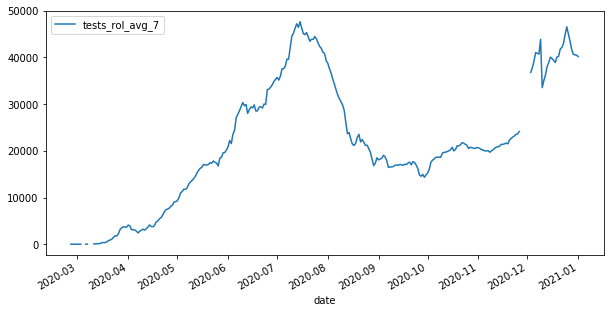

In [122]:
all_daily_data[['tests_rol_avg_7']].plot(figsize=(10,5))

### Index Page Data

In [ ]:
def get_index_page_data():
    def zero_space_format(num):
        is_pos = True if num >= 0 else False
        num = zero_space(num)
        if is_pos:
            num = "+" + num
        else:
            num = "-" + num

        return num

    def zero_space(num):
        return format(num, ',d').replace(",", " ")

    def format_date(date: datetime) -> str:
        return date.strftime("%d/%m/%Y")

    # Tests
    tot_tested = zero_space(tests_data.iloc[-1]['cum_no'].astype(int))
    change_tested = zero_space_format(tests_data.iloc[-1]['daily_no'].astype(int))
    # tmp = tests_data.reset_index()['date'].tail(1)
    last_date_tested = format_date(tests_data.index[-1])
    second_last_date_tested = format_date(tests_data.index[-2])
    sources_tested = tests_data.iloc[-1]['source'] + "," + tests_data.iloc[-2]['source']

    # Confirmed
    tot_confirmed = zero_space(confirmed_data.iloc[-1]['cum_no'].astype(int))
    change_confirmed = zero_space_format(confirmed_data.iloc[-1]['daily_no'].astype(int))
    last_date_confirmed = format_date(confirmed_data.index[-1])
    second_last_date_confirmed = format_date(confirmed_data.index[-2])
    sources_confirmed = confirmed_data.iloc[-1]['source'] + "," + confirmed_data.iloc[-2]['source']

    # Active
    tot_active = zero_space(active_data.iloc[-1]['cum_no'].astype(int))
    change_active = zero_space_format(active_data.iloc[-1]['daily_no'].astype(int))
    last_date_active = format_date(confirmed_data.index[-1])
    second_last_date_active = format_date(confirmed_data.index[-2])

    # Deaths
    tot_deaths = zero_space(deaths_data.iloc[-1]['cum_no'].astype(int))
    change_deaths = zero_space_format(deaths_data.iloc[-1]['daily_no'].astype(int))
    last_date_deaths = format_date(deaths_data.index[-1])
    second_last_date_deaths = format_date(deaths_data.index[-2])
    sources_deaths = deaths_data.iloc[-1]['source'] + "," + deaths_data.iloc[-2]['source']

    # Recoveries
    tot_recoveries = zero_space(recovered_data.iloc[-1]['cum_no'].astype(int))
    change_recoveries = zero_space_format(recovered_data.iloc[-1]['daily_no'].astype(int))
    last_date_recoveries = format_date(recovered_data.index[-1])
    second_last_date_recoveries = format_date(recovered_data.index[-2])
    sources_recoveries = recovered_data.iloc[-1]['source'] + "," + recovered_data.iloc[-2]['source']

    now = datetime.now()
    current_time = now.strftime("%H:%M %d %B %Y")

    _gen_data = pd.DataFrame(dict(
        tot_confirmed=[tot_confirmed], change_confirmed=[change_confirmed], last_date_confirmed=[last_date_confirmed],
        second_last_date_confirmed=[second_last_date_confirmed], sources_confirmed=[sources_confirmed],

        tot_deaths=[tot_deaths], change_deaths=[change_deaths],  last_date_deaths=[last_date_deaths],
        second_last_date_deaths=[second_last_date_deaths], sources_deaths=[sources_deaths],

        tot_active=[tot_active], change_active=[change_active], last_date_active=[last_date_active],
        second_last_date_active=[second_last_date_active],

        tot_tests=[tot_tested], change_tests=[change_tested], last_date_tests=[last_date_tested],
        second_last_date_tests=[second_last_date_tested], sources_tests=[sources_tested],

        tot_recoveries=[tot_recoveries], change_recoveries=[change_recoveries], last_date_recoveries=[last_date_recoveries],
        second_last_date_recoveries=[second_last_date_recoveries], sources_recoveries=[sources_recoveries],

        processed_datetime=[current_time]))

    return _gen_data

index_page_data = get_index_page_data()

In [10]:
# preprocess_sa_data()

,tot_confirmed,change_confirmed,last_date_confirmed,second_last_date_confirmed,sources_confirmed,tot_deaths,change_deaths,last_date_deaths,second_last_date_deaths,sources_deaths,...,change_tests,last_date_tests,second_last_date_tests,sources_tests,tot_recoveries,change_recoveries,last_date_recoveries,second_last_date_recoveries,sources_recoveries,processed_datetime
0,1 073 887,+16 726,01/01/2021,31/12/2020,https://www.nicd.ac.za/latest-confirmed-cases-...,28 887,+418,01/01/2021,31/12/2020,https://www.nicd.ac.za/latest-confirmed-cases-...,...,+50 110,01/01/2021,31/12/2020,https://www.nicd.ac.za/latest-confirmed-cases-...,887 701,+8 030,01/01/2021,31/12/2020,https://www.nicd.ac.za/latest-confirmed-cases-...,14:17 02 January 2021


### Confirmed Data

In [24]:
figsize= (15,8)

In [41]:
confirmed_data

,cum_no,source,daily_no,daily_no_rol_avg_3,daily_no_rol_avg_7
date,,,,,
2020-03-05,1,NaN,1.0,NaN,NaN
2020-03-07,2,NaN,1.0,NaN,NaN
2020-03-08,3,NaN,1.0,1.000000,NaN
2020-03-09,7,NaN,4.0,2.000000,NaN
2020-03-11,13,NaN,6.0,3.666667,NaN
...,...,...,...,...,...
2020-12-28,1011871,https://www.nicd.ac.za/latest-confirmed-cases-...,7458.0,9504.000000,11594.285714
2020-12-29,1021451,https://www.nicd.ac.za/latest-confirmed-cases-...,9580.0,8846.666667,11605.571429
2020-12-30,1039161,https://www.nicd.ac.za/latest-confirmed-cases-...,17710.0,11582.666667,12129.000000


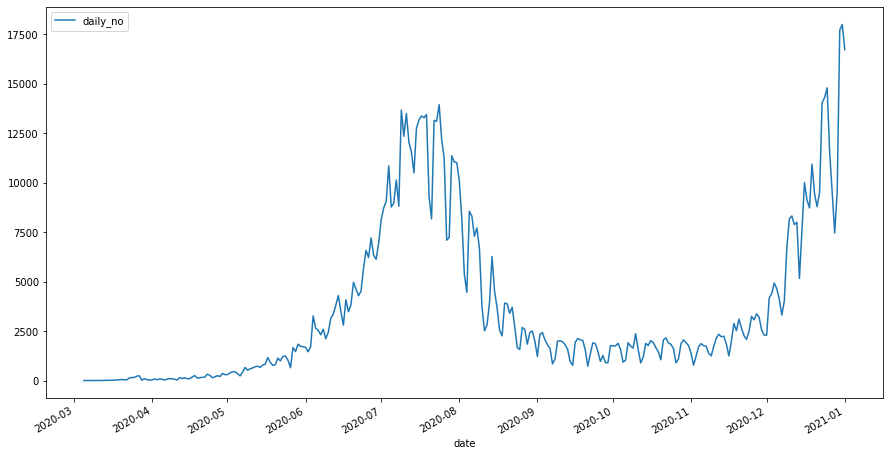

In [39]:
confirmed_data[['daily_no']].plot(figsize=figsize)

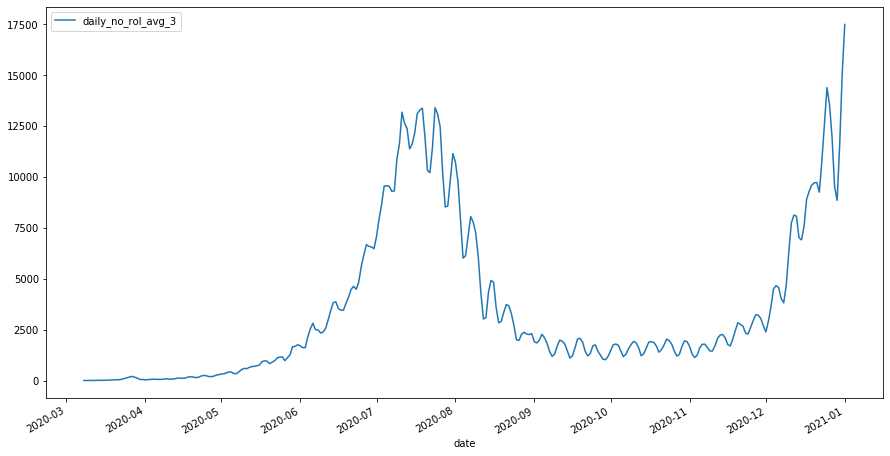

In [42]:
confirmed_data[['daily_no_rol_avg_3']].plot(figsize=figsize)

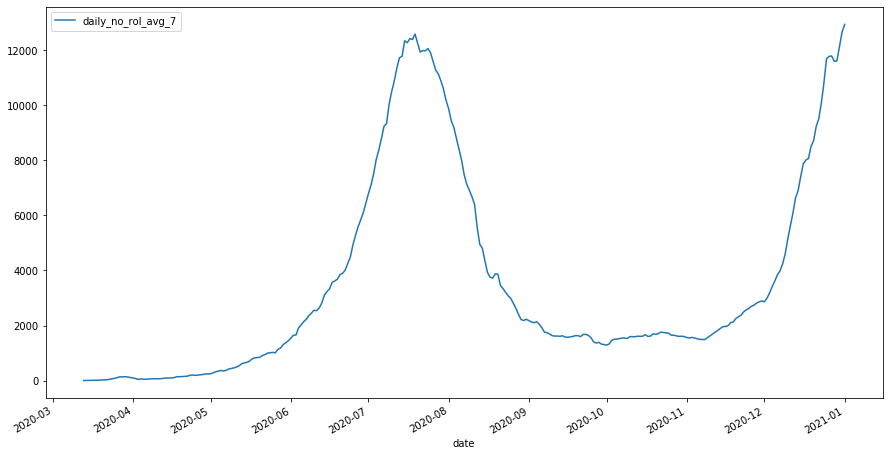

In [43]:
confirmed_data[['daily_no_rol_avg_7']].plot(figsize=figsize)

### Deaths

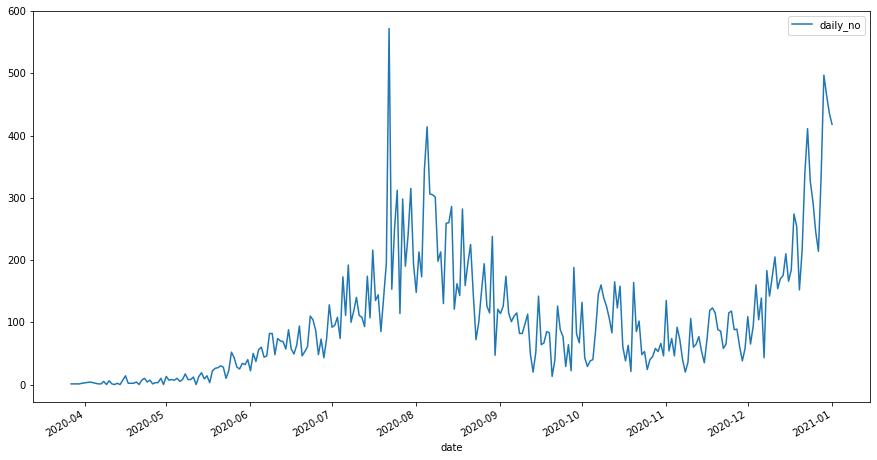

In [113]:
deaths_data[['daily_no']].plot(figsize=figsize)

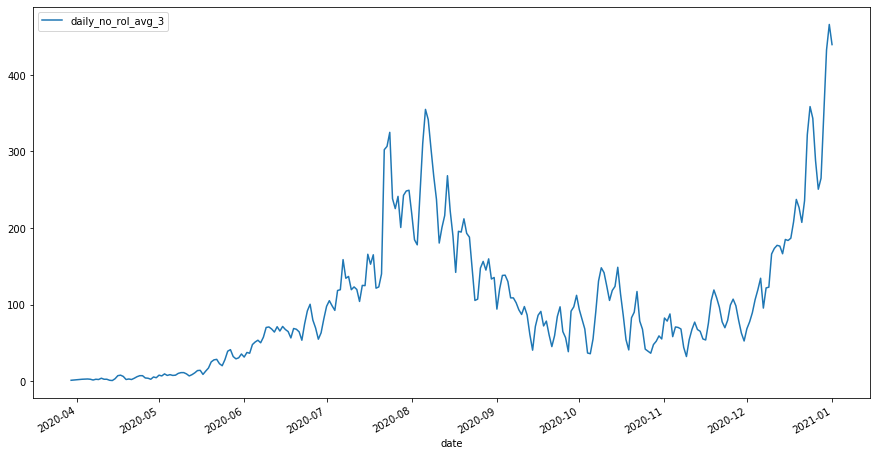

In [44]:
deaths_data[['daily_no_rol_avg_3']].plot(figsize=figsize)